# Final Team Project - SliceWise: Pricing, Menu, and Ratings Analytics for U.S. Pizza Restaurants 

### Team 9: Duy-Anh Dang, Arjun Venkatesh, and Nanch Walker 

Course: ADS 505 Applied Data Science for Business

Instructor: Jules Malin

## Introduction

## Problem Statement

Using the Datafiniti “Pizza Restaurants and the Pizza They Sell (May 2019)” dataset, we will deliver pricing and assortment insights for pizza operators.  

Objectives: 

 

    Profile geographic coverage and market density. 

    Quantify price corridors (store-level priceRangeMin/Max; item-level menus.amountMin/Max). 

    Identify outliers and dispersion by state/city and common SKUs. 

    Provide executive recommendations on pricing, assortment focus, and expansion targets. 

## Exploratory Data Analysis

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import kagglehub
import os 

/opt/homebrew/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Download latest version
path = kagglehub.dataset_download("datafiniti/pizza-restaurants-and-the-pizza-they-sell")

print("Path to dataset files:", path)

Path to dataset files: /Users/nancywalker/.cache/kagglehub/datasets/datafiniti/pizza-restaurants-and-the-pizza-they-sell/versions/2


In [3]:
#Files downloaded
files = os.listdir(path)

In [4]:
# Select the first CSV file (assuming it exists)
csv_files = [f for f in files if f.endswith(".csv")] # Get all CSV file

# Load the first CSV file found
data1 = pd.read_csv(os.path.join(path, csv_files[0]))

# Load the second dataset
data2 = pd.read_csv(os.path.join(path, csv_files[1]))

In [5]:
# print the first few rows of the first dataset
data1.head()

,id,address,categories,city,country,keys,latitude,longitude,menuPageURL,menus.amountMax,...,menus.currency,menus.dateSeen,menus.description,menus.name,name,postalCode,priceRangeCurrency,priceRangeMin,priceRangeMax,province
0,AVwc_6KEIN2L1WUfrKAH,Cascade Village Mall Across From Target,Pizza Place,Bend,US,us/or/bend/cascadevillagemallacrossfromtarget/...,44.102665,-121.300797,NaN,22.50,...,USD,2016-03-31T02:19:42Z,NaN,Bianca Pizza,Little Pizza Paradise,97701,NaN,NaN,NaN,OR
1,AVwc_6KEIN2L1WUfrKAH,Cascade Village Mall Across From Target,Pizza Place,Bend,US,us/or/bend/cascadevillagemallacrossfromtarget/...,44.102665,-121.300797,NaN,18.95,...,USD,2016-03-31T02:19:42Z,NaN,Cheese Pizza,Little Pizza Paradise,97701,NaN,NaN,NaN,OR
2,AVwc_6qRByjofQCxkcxw,148 S Barrington Ave,"American Restaurant,Bar,Bakery",Los Angeles,US,us/brentwood/losangeles/148sbarringtonave/-151...,34.064563,-118.469017,NaN,12.00,...,USD,2015-10-23T03:57:26Z,NaN,"Pizza, Margherita",The Brentwood,90049,USD,50.0,55.0,Brentwood
3,AVwc_6qRByjofQCxkcxw,148 S Barrington Ave,"American Restaurant,Bar,Bakery",Los Angeles,US,us/brentwood/losangeles/148sbarringtonave/-151...,34.064563,-118.469017,NaN,13.00,...,USD,2015-10-23T03:57:26Z,NaN,"Pizza, Mushroom",The Brentwood,90049,USD,50.0,55.0,Brentwood
4,AVwc_6qRByjofQCxkcxw,148 S Barrington Ave,"American Restaurant,Bar,Bakery",Los Angeles,US,us/brentwood/losangeles/148sbarringtonave/-151...,34.064563,-118.469017,NaN,13.00,...,USD,2015-10-23T03:57:26Z,"Olives, onions, capers, tomatoes","Pizza, Puttenesca",The Brentwood,90049,USD,50.0,55.0,Brentwood


In [6]:
# print the first few rows of the second dataset
data2.head()

,id,dateAdded,dateUpdated,address,categories,primaryCategories,city,country,keys,latitude,...,menus.currency,menus.dateSeen,menus.description,menus.name,name,postalCode,priceRangeCurrency,priceRangeMin,priceRangeMax,province
0,AVz3Y-7h3D1zeR_xDAqm,2017-06-30T05:05:40Z,2019-05-01T15:43:09Z,4203 E Kiehl Ave,"Pizza,Restaurant,American restaurants,Pizza Pl...",Accommodation & Food Services,Sherwood,US,us/ar/sherwood/4203ekiehlave/-1051391616,34.832300,...,USD,"2018-05-01T04:25:37.197Z,2018-04-16T04:36:02.3...",NaN,Cheese Pizza,Shotgun Dans Pizza,72120,USD,0,25,AR
1,AVweGPFF_7pvs4fzAAzQ,2016-04-02T04:02:49Z,2019-05-01T15:27:50Z,25 E Camelback Rd,"Pizza,Pizza Place,Restaurants",Accommodation & Food Services,Phoenix,US,us/az/phoenix/25ecamelbackrd/-727422936,33.509266,...,USD,"2018-03-03T02:38:06.381Z,2018-01-18T20:18:10.0...",NaN,Pizza Cookie,Sauce Pizza Wine,85012,USD,0,25,AZ
2,AVwdRGa9_7pvs4fz4E3K,2016-03-03T18:39:49Z,2019-05-01T12:52:25Z,3703 Paxton Ave,"Restaurant,Pizza Place,Restaurants",Accommodation & Food Services,Cincinnati,US,us/oh/cincinnati/3703paxtonave/-619797122,39.144883,...,USD,"2018-04-10T07:58:34.585Z,2018-04-21T05:43:21.4...",a saucelessampcomma double cheese pizza with a...,Pizza Blanca,Mios Pizzeria,45209,USD,0,25,OH
3,AVwdX4psIN2L1WUfvJB1,2016-03-29T05:08:59Z,2019-05-01T12:52:20Z,30495 John R Rd,"Pizza,Carry-out food,Pizza Place,Restaurants",Accommodation & Food Services,Madison Heights,US,us/mi/madisonheights/30495johnrrd/-874863116,42.516669,...,USD,"2016-10-20T21:50:02Z,2016-03-29T05:08:59Z",NaN,Small Pizza,Hungry Howies Pizza,48071,USD,25,40,MI
4,AVwdaeTtkufWRAb55pSH,2016-03-31T02:34:04Z,2019-05-01T12:50:45Z,3600 Eastern Ave,"Pizza,American restaurants,Pizza Place,Pizza e...",Accommodation & Food Services,Baltimore,US,us/md/baltimore/3600easternave/-1270965359,39.286630,...,USD,2016-03-31T02:34:04Z,NaN,Pizza Sub,Spartan Pizzeria,21224,USD,0,25,MD


There are two datasets to use for this project.

data1 is a list of over 3,500 pizzas from multiple restaurants. 
- curated dataset of pizza-only restaurants in Datafiniti's business database. 
- Useful for pizza-specific analyses.

Data2 is a list of 10,000 pizza restaurants in Datafiniti's business database, spanning **from January 2018 to May 2019**.
- larger, broader subset of Datafiniti's business database.
- useful to analyze pizza restaurants in comparison to other types of restaurants. 

In [7]:
data1.info()
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3510 entries, 0 to 3509
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  3510 non-null   object 
 1   address             3510 non-null   object 
 2   categories          3510 non-null   object 
 3   city                3510 non-null   object 
 4   country             3510 non-null   object 
 5   keys                3510 non-null   object 
 6   latitude            3510 non-null   float64
 7   longitude           3510 non-null   float64
 8   menuPageURL         610 non-null    object 
 9   menus.amountMax     2948 non-null   float64
 10  menus.amountMin     2948 non-null   float64
 11  menus.currency      2951 non-null   object 
 12  menus.dateSeen      3510 non-null   object 
 13  menus.description   1526 non-null   object 
 14  menus.name          3510 non-null   object 
 15  name                3510 non-null   object 
 16  postal

This project uses two datasets. 

Dataset 1: 8358_1.csv 
- This dataset contains information on pizza restaurants and the types of Pizza they sell.
- It has 3,519 rows and 21 columns.
- There are a few features with missing values.

Dataset 2: Datafiniti_Pizza_Restaurants_and_the_Pizza_They_Sell_May19.csv
- list of 10,000 restaurants in Datafiniti's business database between January 2018 and May 2019
- There are 24 feature columns
- Business listings include a variation of the phrase Pizza within the categories and menu.name variables 
- fields have been flattened to make it easier to work with
- This dataset is a sample of a larger dataset that is available through Datafiniti's business database.


## Data2 Datafiniti Pizza Restaurants and the Pizza They Sell (May19)

In [8]:
# Data distribution
data2.describe()

,latitude,longitude,menus.amountMax,menus.amountMin,priceRangeMin,priceRangeMax
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,38.371895,-90.063800,14.032670,13.416902,4.655500,27.764200
std,4.573537,17.340379,17.607233,10.742678,9.828412,6.017526
min,21.421326,-157.802443,0.000000,0.000000,0.000000,7.000000
25%,34.422946,-104.801126,8.490000,8.000000,0.000000,25.000000
50%,40.118880,-82.909949,13.390000,12.990000,0.000000,25.000000
75%,40.905048,-75.194741,17.950000,16.990000,0.000000,25.000000
max,64.850500,-71.946170,1395.000000,243.000000,50.000000,55.000000


In [9]:
# Check for missing values
data1.isnull().sum()

id                       0
address                  0
categories               0
city                     0
country                  0
keys                     0
latitude                 0
longitude                0
menuPageURL           2900
menus.amountMax        562
menus.amountMin        562
menus.currency         559
menus.dateSeen           0
menus.description     1984
menus.name               0
name                     0
postalCode              26
priceRangeCurrency    1953
priceRangeMin         1953
priceRangeMax         1953
province                 0
dtype: int64

There are a few features with missing values.

- menuPageURL - 2,900 missing values ( Identifier/Link to the menu page on the business's website), leave as null and drop column
- menu.amountMax - 562 missing values ( Maximum price of the menu item), impute with median
- menus.amountMin - 562 missing values ( Minimum price of the menu item), impute with median
- menus.currency - 559 missing values ( Currency of the menu item price), impute with mode
- menus.description - 1984 missing values ( Description of the menu item)
    - Options: drop column, impute with placeholder string (for NLP), or transform to binary variable
- postalCode - 26 missing values ( Postal code of the business), impute with mode
- priceRangeCurrency - 1953 missing values ( Currency of the price range), impute with mode
- priceRangeMin - 1953 missing values ( Minimum price of the price range), impute with median
- priceRangeMax - 1953 missing values ( Maximum price of the price range), impute with median


In [10]:
# Remove identifier columns for modeling
data2_cleaned = data2.drop(columns=['id', 'categories', 'address', 'keys', 'menuPageURL']).copy()

# Impute missing values for numeric columns with the mean
num_cols = data2_cleaned.select_dtypes(include=['float64', 'int64']).columns
data2_cleaned[num_cols] = data2_cleaned[num_cols].fillna(data2_cleaned[num_cols].mean())

# Impute missing values for categorical columns with the mode
cat_cols = ['menus.currency', 'postalCode','priceRangeCurrency']
for col in cat_cols:
    mode_value = data2_cleaned[col].mode()[0]
    data2_cleaned[col] = data2_cleaned[col].fillna(mode_value)

# Create binary feature for menus.description and drop original column
data2_cleaned['has_description'] = np.where(data2_cleaned['menus.description'].notnull(), 1, 0)
data2_cleaned = data2_cleaned.drop(columns=['menus.description'])

# Verify no missing values remain
data2_cleaned.isnull().sum()

dateAdded             0
dateUpdated           0
primaryCategories     0
city                  0
country               0
latitude              0
longitude             0
menus.amountMax       0
menus.amountMin       0
menus.currency        0
menus.dateSeen        0
menus.name            0
name                  0
postalCode            0
priceRangeCurrency    0
priceRangeMin         0
priceRangeMax         0
province              0
has_description       0
dtype: int64

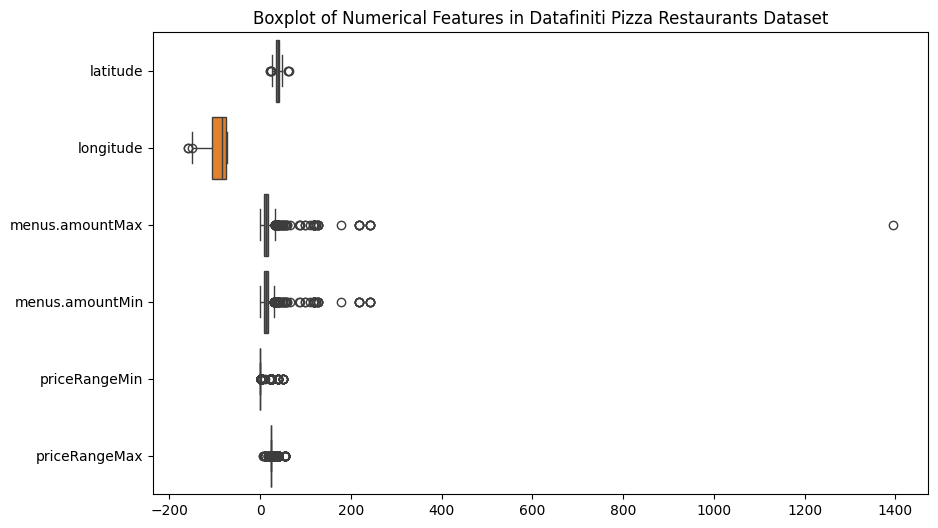

In [ ]:
# Select numerical columns in Dataset 2
num_columns = data2_cleaned.select_dtypes(include=['float64','int64']).columns

# Boxplot for numerical features in Dataset 2
plt.figure(figsize=(10,6))
sns.boxplot(data=data2_cleaned[num_cols], orient='h')
plt.title('Boxplot of Numerical Features in Datafiniti Pizza Restaurants Dataset')
plt.xticks(rotation=45)
plt.show()


Menus.amountMax has an extreme outlier of a pizza that cost $1,395. This extreme value may be due to a data entry error or an expensive restaurant selling a luxury pizza. The outlier can be removed for analysis

In [15]:
# remove the outlier in menus.amountMax
data2_cleaned = data2_cleaned[data2_cleaned['menus.amountMax']<500]


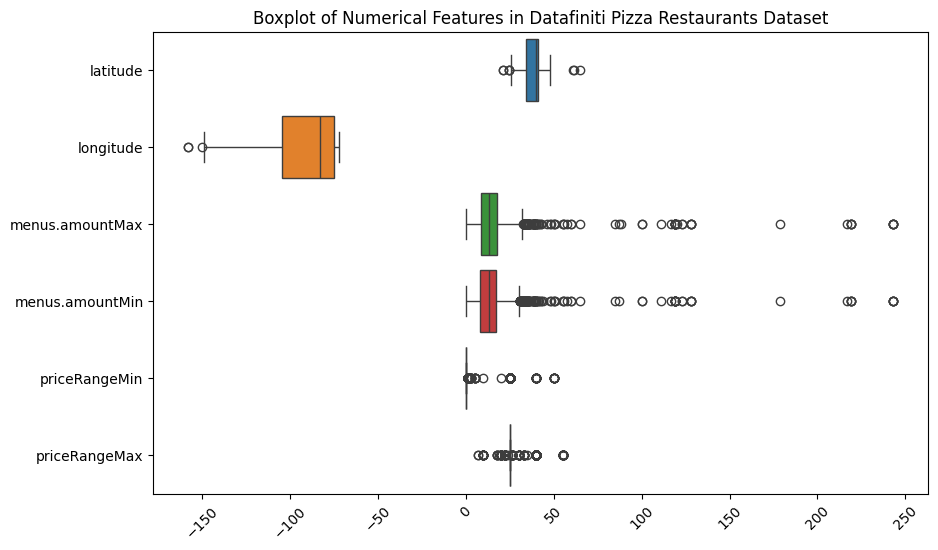

In [16]:
# Recheck data distribution after removig outlier
# Boxplot for numerical features in Dataset 2
plt.figure(figsize=(10,6))
sns.boxplot(data=data2_cleaned[num_cols], orient='h')
plt.title('Boxplot of Numerical Features in Datafiniti Pizza Restaurants Dataset')
plt.xticks(rotation=45)
plt.show()

A clear distribution of numerical feature can be seen once the extream outleir is removed. 

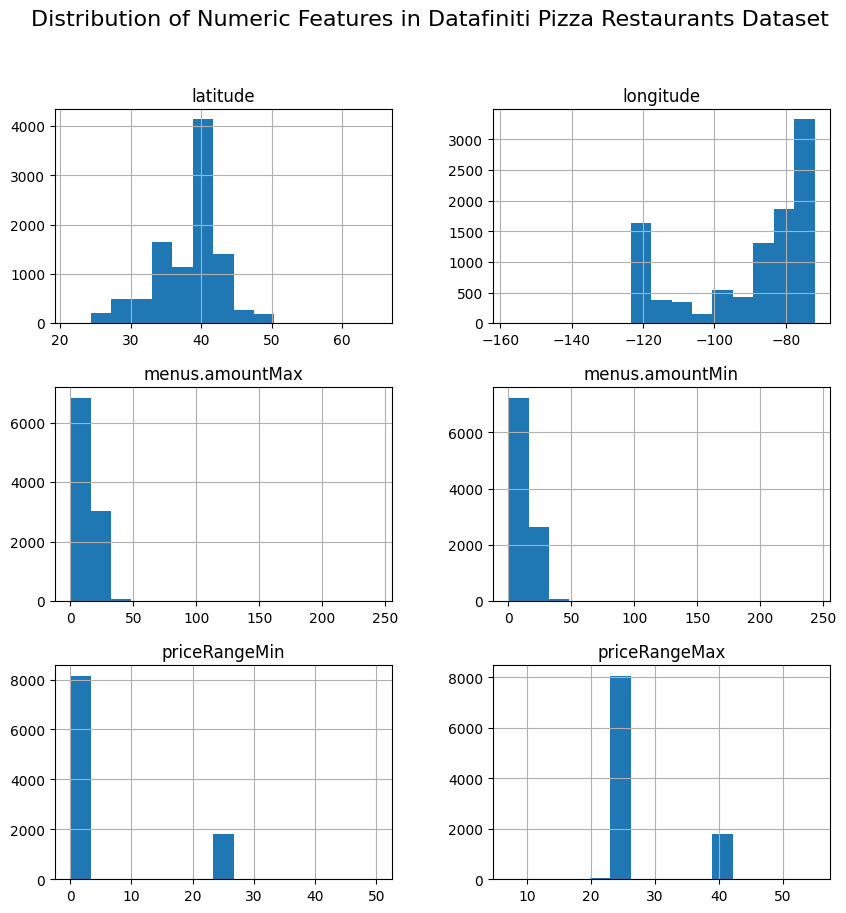

In [22]:
# Feature distribution of numeric features in Dataset 2 
data2_cleaned[num_cols].hist(figsize=(10,10),bins=15)
plt.suptitle("Distribution of Numeric Features in Datafiniti Pizza Restaurants Dataset", fontsize =16)
plt.show()

This histogram also provides a clear visualization of the distribution of the numeric feature. 

Longitude and latitude are continuous variables and display pizza location information.
-Options: keep as is, view mapping, compute distance reference point, group into regions, or use postal code/ city/ province/state to group instead of raw coordinates. 

menus.ammount Max and Min are continuous variabels that display the price range of menu items. These variables are skewed right. (will need normalization/transformation for modeling)

priceRange Min and Max look as though they are categorical variables with numeric values. Likely displaying similar information to menus.amount Max and Min.

<Axes: >

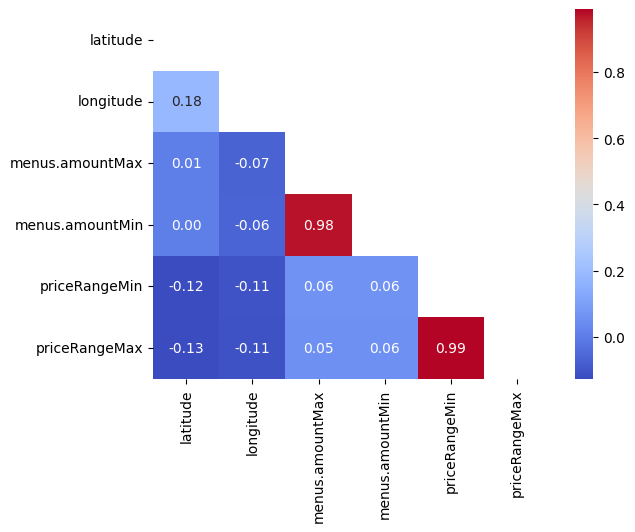

In [23]:
# Plot heatmap to visualize correlations
plt.figuresize=(10,8)
# creating mask to display only one triangle of the heatmap
mask = np.triu(np.ones_like(data2_cleaned[num_cols].corr()))

sns.heatmap(data2_cleaned[num_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm', mask=mask)

Menus.amountMin and menus.amountMax are highly correlated (r = 0.98). One of these variables can be removed for modeling.

pricRangeMin and priceRangeMax are also highly correlated (0.99). One of these variables can be removed for modeling.

Will keep menus.amountMax, and priceRangeMax for modeling.

In [24]:
# Drop highly correlated features
data2_cleaned = data2_cleaned.drop(columns=['menus.amountMin', 'priceRangeMin'])

In [ ]:
# Check the unique values across all columns in Dataset 2
data2_cleaned.nunique()

dateAdded             2214
dateUpdated           2193
primaryCategories        8
city                  1028
country                  1
latitude              2284
longitude             2284
menus.amountMax        772
menus.currency           1
menus.dateSeen        6303
menus.name            4749
name                  1827
postalCode            1771
priceRangeCurrency       1
priceRangeMax           14
province                44
has_description          2
dtype: int64

## Data Wrangling and Pre-Processing

## Data Splitting

## Modeling Strategy

# Validation and Testing 

# Results and final model selection

# Discussion and Conclusion